# Библиотеки

In [ ]:
import numpy as np
import pandas as pd
import pickle
import xml.etree.ElementTree as ET
import json

from sklearn.metrics import mean_squared_error
from catboost import CatBoost, CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import ParameterGrid, KFold
from tqdm import tqdm
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# Предобработка

Считывание и построения дерева XML файла

In [ ]:
soup = BeautifulSoup(open('data/fantasy1984.xml', mode='r', encoding='utf-8'), 'xml')

Список уникальных тегов

In [ ]:
set([tag.name for tag in soup.findChildren()])

{'FirstSentence',
 'LastSentence',
 'allophone',
 'content',
 'dictitem',
 'intonation',
 'letter',
 'pause',
 'phoneme',
 'sentence',
 'stress',
 'text',
 'word'}

In [ ]:
allie = [el.get('ph').lower() for el in BeautifulSoup(open('data/AlyieParusa.xml', mode='r', encoding='utf-8'), 'xml').find_all('allophone')]

In [ ]:
fantasy1984 = [el.get('ph').lower() for el in BeautifulSoup(open('data/fantasy1984.xml', mode='r', encoding='utf-8'), 'xml').find_all('allophone')]

Обработка и получение признаков

In [ ]:
def get_features(xml_filename: str = None, csv_filename: str = None):
    list_of_all_allophones = ["<sos>", "<eos>", "a0", "a1", "a2", "a4", "b", "b'", "c", "ch", "C", "CH", "d", "d'", "e0", "e1", "e2", "e4", "f", "f'", "g", "g'", "h", "h'", "H", "i0", "i1", "i2", "i4", "j", "k", "k'", "l", "l'", "m", "m'", "n", "n'", "o0", "o1", "o2", "o4", "p", "p'", "r", "r'", "s", "sc", "sch", "sh", "SC", "s'", "t", "t'", "u0", "u1", "u2", "u4", "v", "v'", "y0", "y1", "y2", "y4", "z", "zh", "z'"]
    list_of_all_letters = ["<sos>", "<eos>", "а", "б", "в", "г", "д", "е", "ё", "ж", "з", "и", "й", "к", "л", "м", "н", "о", "п", "р", "с", "т", "у", "ф", "х", "ц", "ч", "ш", "щ", "ъ", "ы", "ь", "э", "ю", "я", '-']
    dict_allophones = {value: idx for idx, value in enumerate(list_of_all_allophones)}
    dict_letter = {value: idx for idx, value in enumerate(list_of_all_letters)}
    pause_dict = {'no': -1, 'long': 1, 'weak': 2, 'spelling': 3, 'minimal': 4}
    
    soup = BeautifulSoup(open(xml_filename, mode='r', encoding='utf-8'), 'xml')
    
    original = []
    lenWord = []
    wordForm = []
    # Знаки препинания и эмфазы на слове
    punktEnd = []
    punktBeg = []
    emphEnd = []
    emphBeg = []
    # Паузы
    isPause = []
    lenPause = []
    # Слова
    nucleus = []
    semantics1 = []
    semantics2 = []
    countBeforeWords = []
    countAfterWords = []
    beforeWords = []
    afterWords = []
    capitalized = []
    indexInSentence = []
    subpartOfSpeech = []

    for sentence in soup.find_all('sentence'):
        for i, el in enumerate(sentence.findChildren()):
            if el.name == 'content':
                if el.get('PauseType'):
                    isPause.append(1)
                else:
                    isPause.append(0)

                punktBeg.append(el.get('PunktBeg'))
                punktEnd.append(el.get('PunktEnd'))
                emphEnd.append(el.get('EmphEnd'))
                emphBeg.append(el.get('EmphBeg'))

            if el.name == 'pause':
                lenPause.append(int(el.get('time')))

            if el.name == 'word':
                lenWord.append(len(el.get('original')) if el.get('original') else 0)
                original.append(el.get('original'))
                nucleus.append(el.get('nucleus'))
                wordForm.append(int(el.find('dictitem').get('form')))
                semantics1.append(el.find('dictitem').get('semantics1'))
                semantics2.append(el.find('dictitem').get('semantics2'))
                subpartOfSpeech.append(el.find('dictitem').get('subpart_of_speech'))

                indexInSentence.append(i)

                if original[-1]:
                    capitalized.append(original[-1] == original[-1].lower().capitalize())
                else:
                    capitalized.append(None)



    for i, v in enumerate(original):
        countAfterWords.append(len(original) - i)
        countBeforeWords.append(i)

        if i == 0:
            beforeWords.append(None)
        else:
            beforeWords.append(original[i - 1])

        if i == len(original) - 1:
            afterWords.append(None)
        else:
            afterWords.append(original[i + 1])

    # Ставим метки длины пауз
    pauses = 0
    newLenPause = []
    for i in range(len(isPause)):
        if isPause[i]:
            newLenPause.append(lenPause[pauses])
            pauses += 1
        else:
            newLenPause.append(-1)
    lenPause = newLenPause

    # Переводим данные в pandas.DataFrame

    df = pd.DataFrame()

    df['original'] = original
    df['lenWord'] = lenWord
    df['wordForm'] = wordForm
    # Знаки препинания и эмфазы на слове
    df['punktEnd'] = punktEnd
    df['punktBeg'] = punktBeg
    df['emphEnd'] = emphEnd
    df['emphBeg'] = emphBeg
    # Паузы
    df['isPause'] = isPause
    df['lenPause'] = lenPause
    # Слова
    df['nucleus'] = nucleus
    df['semantics1'] = semantics1
    df['semantics2'] = semantics2
    df['countBeforeWords'] = countBeforeWords
    df['countAfterWords'] = countAfterWords
    df['beforeWords'] = beforeWords
    df['afterWords'] = afterWords
    df['capitalized'] = capitalized
    df['indexInSentence'] = indexInSentence
    df['subpartOfSpeech'] = subpartOfSpeech
    df['nucleus_labels'] = [el == '2' for el in nucleus]

    df = df.fillna('None') # Заполняем пустые места строкой

    df.to_csv(csv_filename)

    return df

In [ ]:
df = get_features(xml_filename='data/fantasy1984.xml', csv_filename='markup/df.csv')

Смотрим на распределения данных

array([[<Axes: title={'center': 'lenWord'}>,
        <Axes: title={'center': 'wordForm'}>,
        <Axes: title={'center': 'isPause'}>],
       [<Axes: title={'center': 'lenPause'}>,
        <Axes: title={'center': 'countBeforeWords'}>,
        <Axes: title={'center': 'countAfterWords'}>],
       [<Axes: title={'center': 'indexInSentence'}>, <Axes: >, <Axes: >]],
      dtype=object)

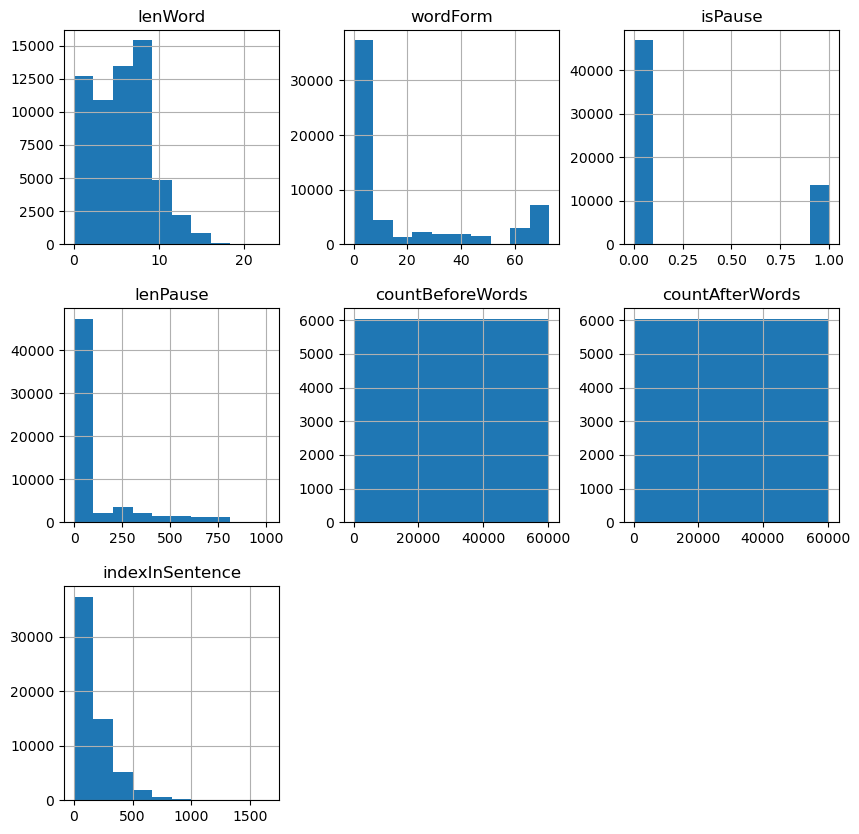

In [ ]:
df.hist(figsize=(10, 10))

Сделаем обработку для второго файла (а данном случае Алые Паруса)

In [ ]:
df_val = get_features(xml_filename='data/AlyieParusa.xml', csv_filename='markup/df_test.csv')

Распределения для текста Алые Паруса

array([[<Axes: title={'center': 'lenWord'}>,
        <Axes: title={'center': 'wordForm'}>,
        <Axes: title={'center': 'isPause'}>],
       [<Axes: title={'center': 'lenPause'}>,
        <Axes: title={'center': 'countBeforeWords'}>,
        <Axes: title={'center': 'countAfterWords'}>],
       [<Axes: title={'center': 'indexInSentence'}>, <Axes: >, <Axes: >]],
      dtype=object)

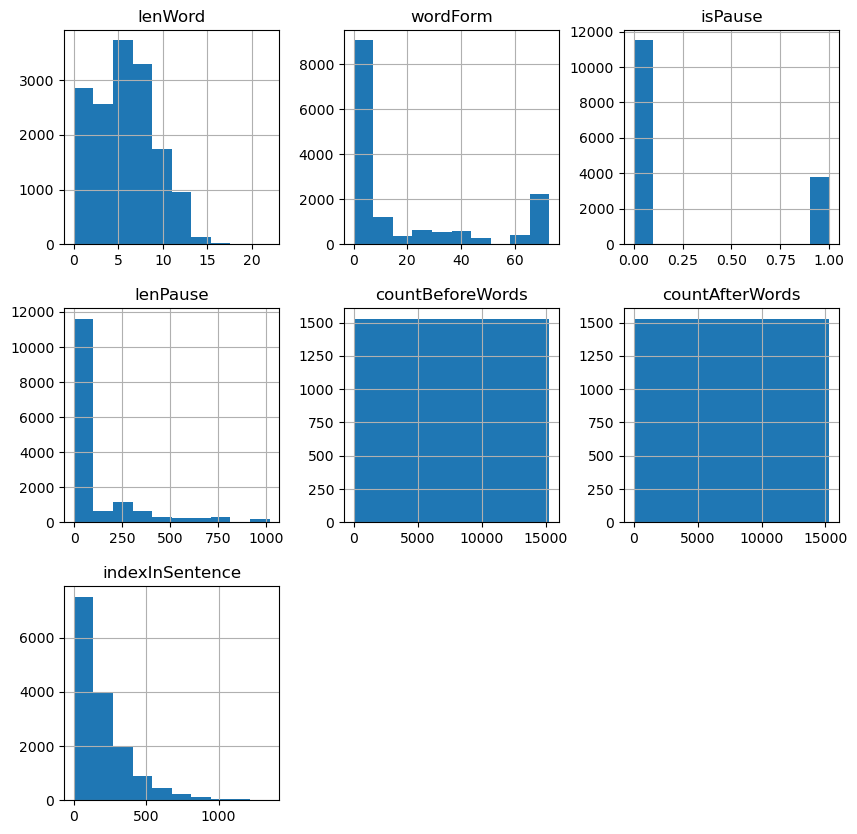

In [ ]:
df_val.hist(figsize=(10, 10))

Нормализация данных

In [ ]:
df_t = deepcopy(df)
df_t.drop(['word', 'mfcc'], axis=1, inplace=True)

scaler = StandardScaler()
X = scaler.fit_transform(df_t)
df_scaler = pd.DataFrame(X, columns=df_t.columns)
df_scaler['mfcc'] = df['mfcc']

In [ ]:
# Save the scaler
with open('acoustics/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
X_train, X_test = train_test_split(df_scaler, test_size=0.1, random_state=42, shuffle=False)
X_test.reset_index(inplace=True)
X_test.drop('index', inplace=True, axis=1)
columns = list(X_train.columns)
columns.remove('mfcc')

# Обучение

In [ ]:
def catboost_GridSearchCV(X, y, params, n_splits=2):
    ps = {'rmse': 100,
          'param': []
    }
    
    predict=None
    
    for prms in tqdm(list(ParameterGrid(params)), ascii=True, desc='Params Tuning:'):
        print(prms)
                          
        rmse = cross_val(X, y, prms, n_splits=n_splits)

        if rmse<ps['rmse']:
            ps['rmse'] = rmse
            ps['param'] = prms
    print(f"RMSE: {str(ps['rmse'])}")
    print(f"Params: {str(ps['param'])}")
    
    return ps['param']

In [ ]:
def cross_val(X, y, param,n_splits=3):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    rmse_list = []
    predict = None
    
    for tr_ind, val_ind in kfold.split(X, y):
#         print(tr_ind)
        X_train = X.loc[tr_ind]
        y_train = y.loc[tr_ind]
        
        X_valid = X.loc[val_ind]
        y_valid = y.loc[val_ind]
        
        clf = CatBoostRegressor(iterations=1000,
                                loss_function = 'MultiRMSE',
                                depth=param['depth'],
                                l2_leaf_reg = param['l2_leaf_reg'],
                                eval_metric = 'MultiRMSE',
                                use_best_model=True,
                                task_type="GPU",
                                learning_rate=1,
                                metric_period=100
        )
        
        clf.fit(X_train, 
                y_train,
                eval_set=(X_valid, y_valid)
        )
        
        y_pred = clf.predict(X_valid)
        rmse = mean_squared_error(y_valid, y_pred)
        rmse_list.append(rmse)
        break
    return sum(rmse_list)/n_splits

In [ ]:
X = deepcopy(df_scaler)
y = pd.DataFrame([np.array(x.split('|')[1:-1], dtype=float) for x in X['mfcc']])
X.drop('mfcc', axis=1, inplace=True)

In [ ]:
reg = np.logspace(-20, -19, 1)
reg = np.append(reg, [3, 10])
params = {'depth': [4, 6, 10],
          'l2_leaf_reg': reg
}

param = catboost_GridSearchCV(X, y, params)
print(param)

In [ ]:
x_train = deepcopy(X_train)
y_train = pd.DataFrame(np.array(x.split('|')[1:-1], dtype=float) for x in x_train['mfcc'])
x_train.drop('mfcc', axis=1, inplace=True)

x_test = deepcopy(X_test)
y_test = pd.DataFrame(np.array(x.split('|')[1:-1], dtype=float) for x in x_test['mfcc'])
x_test.drop('mfcc', axis=1, inplace=True)

In [ ]:
params = {'learning_rate': 0.3, 
          'depth': 6, 
          'l2_leaf_reg': 10.0, 
          'loss_function': 'MultiRMSE', 
          'eval_metric': 'MultiRMSE', 
          'task_type': 'GPU', 
          'iterations': 2000,
          'use_best_model': True,
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bernoulli', 
          'allow_const_label': True, 
          'metric_period': 50
         }
model_reg = CatBoostRegressor(**params)
model_reg.fit(x_train, y_train,eval_set=(x_test, y_test))

In [ ]:
y_predict = model_reg.predict(x_test)

In [ ]:
cos_dist = []
cos_sim = []
for x, y in tqdm(zip(y_predict, np.array(y_test)), total=len(y_test)):
    cos_dist.append(cosine_distances([x], [y]))
    cos_sim.append(cosine_similarity([x], [y]))

In [ ]:
with open('acoustics/catboost_regressor_best.pkl', 'wb') as f:
    pickle.dump(model_reg, f)

# Тестирование

Функция для проведения тестирования

In [ ]:
def test(filename: str = None) -> None:
    df = get_features(xml_filename=filename, csv_filename='test.csv')

    with open('acoustics/catboost_regressor_best.pkl', 'rb') as f:
        model = pickle.load(f)

    mffcs = model.predict(df)

    result = {'words': []}

    for i, v in enumerate(df['original']):
        word = {}
        word['content'] = v
        word['mffcs'] = mfccs[i]
        result['words'].append(word)
    
    import json
    with open('test.json', mode='w+', encoding='utf-8') as file:
        json.dump([result], file, indent=4, ensure_ascii=False)

Вызов функции для тестирования и получения json файла. В аргументы пишется название файла разметки

In [ ]:
test('data/fantasy1984.xml')